In [1]:
import logging
import tensorflow as tf


GPU_FROM = 3
GPU_TO = 4

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-01-26 12:53:01.224565: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-26 12:53:01.365734: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-26 12:53:01.402222: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-26 12:53:02.063206: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [15]:
import string
import html
import tensorflow_datasets as tfds

from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids

punc_mapping = {ord(x):x for x in string.punctuation}
entity_mapping = {f" ?{k}": v for k, v in html.entities.html5.items() if k.endswith(";") and v in string.punctuation}
punc_mapping = {f' ?&?#?{k};': v for k, v in punc_mapping.items()}

train, test = tfds.load('ag_news_subset', split="train"), tfds.load('ag_news_subset', split="test")

def unescape(text):
    for match, replace in punc_mapping.items():
        text = tf.strings.regex_replace(text, match, replace)
    for match, replace in entity_mapping.items():#
        text = tf.strings.regex_replace(text, match, replace)
    return text

def join_title_desc(text_dict):
    return text_dict['title'] + ' ' + text_dict['description']

train = train.map(join_title_desc).map(unescape).filter(lambda x: tf.strings.length(x) > 100)
test = test.map(join_title_desc).map(unescape).filter(lambda x: tf.strings.length(x) > 100)

for x in train.take(1):
    print(x)

tf.Tensor(b"AMD Debuts Dual-Core Opteron Processor AMD's new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.", shape=(), dtype=string)


2023-01-26 12:59:42.737204: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [16]:

def generate_labels(text):
    max_chars = 100

    last_char = tf.strings.substr(text, max_chars, max_chars+1)
    text = tf.strings.substr(text,0, max_chars)
    text = tf.strings.lower(text)
    split_on_whitespace = tf.strings.strip(tf.strings.split(text))
    encoder_in = tf.strings.reduce_join(split_on_whitespace, axis=-1)
    
    space_indices = tf.math.cumsum(tf.strings.length(split_on_whitespace)) - 1 # subtract 1 to index from 0
    seq_len = space_indices[-1] + 1
    if not tf.strings.regex_full_match(last_char, " "):
        space_indices = space_indices[:-1]
    encoder_out = tf.ones((max_chars,))
    encoder_out = tf.concat([
        tf.ones((seq_len,)),
        tf.zeros((max_chars - seq_len,))
    ], axis=-1)
    encoder_out = tf.tensor_scatter_nd_update(
        encoder_out, 
        space_indices[...,tf.newaxis], # Expand dims to create a 'list' of indices
        tf.ones_like(space_indices, dtype=encoder_out.dtype)*2) 
    
    return (encoder_in, None), tf.cast(encoder_out, "float16")

train = train.map(generate_labels)
val = test.map(generate_labels)
for x in train.take(1):
    print(x)

((<tf.Tensor: shape=(), dtype=string, numpy=b"amddebutsdual-coreopteronprocessoramd'snewdual-coreopteronchipisdesignedmainlyforcorpo">, None), <tf.Tensor: shape=(100,), dtype=float16, numpy=
array([1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 2., 1., 1., 2., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float16)>)


2023-01-26 12:59:49.878079: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [17]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train.map(lambda x,y: x[0]).take(1000))
tokenizer.get_vocabulary()

2023-01-26 12:59:56.621126: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


['',
 '[UNK]',
 'e',
 'a',
 's',
 't',
 'o',
 'i',
 'r',
 'n',
 'l',
 'd',
 'c',
 'h',
 'u',
 'p',
 'm',
 'f',
 'g',
 'b',
 'w',
 'y',
 'k',
 'v',
 '-',
 ',',
 '.',
 "'",
 '(',
 ')',
 'x',
 '0',
 'j',
 'q',
 '2',
 '1',
 '&',
 ':',
 'z',
 '3',
 '4',
 '<',
 '"',
 '\\',
 '5',
 '>',
 '/',
 '7',
 '6',
 '$',
 '8',
 '9',
 ';',
 '?',
 '=',
 '!',
 '#',
 '*']

In [18]:
D_MODEL = 512

model = SpaceSegmentationTransformer(
    num_layers=2,
    d_model=D_MODEL,
    num_attention_heads=3,
    seq_len=100,
    dff=1028,
    input_tokenizer=tokenizer,
    dropout_rate=0.1
)

In [19]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=200):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return 2* tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0.),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [20]:
train_ds = train.shuffle(100).batch(8)
val_ds = val.batch(8)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_space_precision",
        patience=100,
        mode="max",
        restore_best_weights=True
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=100, 
    callbacks=callbacks, 
    steps_per_epoch=10,
    validation_freq=10
    )

Epoch 1/100
 7/10 [====================>.........] - ETA: 0s - loss: 0.9525 - sparse_categorical_accuracy: 0.6300 - space_precision: 0.1611 - space_recall: 0.0867 - space_f1: 0.1127 - char_precision: 0.7202 - char_recall: 0.7570 - char_f1: 0.7381

2023-01-26 13:00:07.515761: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - ETA: 0s - loss: 0.8811 - sparse_categorical_accuracy: 0.6492 - space_precision: 0.1760 - space_recall: 0.1523 - space_f1: 0.1633 - char_precision: 0.7197 - char_recall: 0.7660 - char_f1: 0.7421WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 5s 22ms/step - loss: 0.8811 - sparse_categorical_accuracy: 0.6492 - space_precision: 0.1760 - space_recall: 0.1523 - space_f1: 0.1633 - char_precision: 0.7197 - char_recall: 0.7660 - char_f1: 0.7421
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.5457 - sparse_categorical_accuracy: 0.7821 - space_precision: 0.2854 - space_recall: 0.2026 - space_f1: 0.2369 - char_precision: 0.7035 - char_recall: 0.9151 - char_f1: 0.7955 WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.5457 - sparse_categorical_accuracy: 0.7821 - space_precision: 0.2854 - space_recall: 0.2026 - space_f1: 0.2369 - char_precision: 0.7035 - char_recall: 0.9151 - char_f1: 0.7955
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.4737 - sparse_categorical_accuracy: 0.8047 - space_precision: 0.4073 - space_recall: 0.1427 - space_f1: 0.2114 - char_precision: 0.6907 - char_recall: 0.9557 - char_f1: 0.8019 WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4737 - sparse_categorical_accuracy: 0.8047 - space_precision: 0.4073 - space_recall: 0.1427 - space_f1: 0.2114 - char_precision: 0.6907 - char_recall: 0.9557 - char_f1: 0.8019
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.4476 - sparse_categorical_accuracy: 0.8160 - space_precision: 0.4453 - space_recall: 0.1470 - space_f1: 0.2210 - char_precision: 0.7027 - char_recall: 0.9630 - char_f1: 0.8125WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4476 - sparse_categorical_accuracy: 0.8160 - space_precision: 0.4453 - space_recall: 0.1470 - space_f1: 0.2210 - char_precision: 0.7027 - char_recall: 0.9630 - char_f1: 0.8125
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 0.4334 - sparse_categorical_accuracy: 0.8199 - space_precision: 0.5289 - space_recall: 0.1408 - space_f1: 0.2224 - char_precision: 0.6980 - char_recall: 0.9724 - char_f1: 0.8126WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4334 - sparse_categorical_accuracy: 0.8199 - space_precision: 0.5289 - space_recall: 0.1408 - space_f1: 0.2224 - char_precision: 0.6980 - char_recall: 0.9724 - char_f1: 0.8126
Epoch 6/100
10/10 [==============================] - ETA: 0s - loss: 0.4240 - sparse_categorical_accuracy: 0.8218 - space_precision: 0.5863 - space_recall: 0.1307 - space_f1: 0.2138 - char_precision: 0.6949 - char_recall: 0.9790 - char_f1: 0.8128WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4240 - sparse_categorical_accuracy: 0.8218 - space_precision: 0.5863 - space_recall: 0.1307 - space_f1: 0.2138 - char_precision: 0.6949 - char_recall: 0.9790 - char_f1: 0.8128
Epoch 7/100
10/10 [==============================] - ETA: 0s - loss: 0.4633 - sparse_categorical_accuracy: 0.8144 - space_precision: 0.4654 - space_recall: 0.2028 - space_f1: 0.2825 - char_precision: 0.7033 - char_recall: 0.9504 - char_f1: 0.8084WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4633 - sparse_categorical_accuracy: 0.8144 - space_precision: 0.4654 - space_recall: 0.2028 - space_f1: 0.2825 - char_precision: 0.7033 - char_recall: 0.9504 - char_f1: 0.8084
Epoch 8/100
10/10 [==============================] - ETA: 0s - loss: 0.4881 - sparse_categorical_accuracy: 0.8114 - space_precision: 0.4262 - space_recall: 0.1699 - space_f1: 0.2430 - char_precision: 0.7015 - char_recall: 0.9535 - char_f1: 0.8083WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4881 - sparse_categorical_accuracy: 0.8114 - space_precision: 0.4262 - space_recall: 0.1699 - space_f1: 0.2430 - char_precision: 0.7015 - char_recall: 0.9535 - char_f1: 0.8083
Epoch 9/100
10/10 [==============================] - ETA: 0s - loss: 0.4509 - sparse_categorical_accuracy: 0.8204 - space_precision: 0.5405 - space_recall: 0.1352 - space_f1: 0.2163 - char_precision: 0.6972 - char_recall: 0.9742 - char_f1: 0.8127WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4509 - sparse_categorical_accuracy: 0.8204 - space_precision: 0.5405 - space_recall: 0.1352 - space_f1: 0.2163 - char_precision: 0.6972 - char_recall: 0.9742 - char_f1: 0.8127
Epoch 10/100
10/10 [==============================] - 13s 1s/step - loss: 0.4247 - sparse_categorical_accuracy: 0.8282 - space_precision: 0.6339 - space_recall: 0.1311 - space_f1: 0.2173 - char_precision: 0.7010 - char_recall: 0.9832 - char_f1: 0.8184 - val_loss: 0.4167 - val_sparse_categorical_accuracy: 0.8154 - val_space_precision: 0.4973 - val_space_recall: 0.3103 - val_space_f1: 0.3821 - val_char_precision: 0.7071 - val_char_recall: 0.9293 - val_char_f1: 0.8031
Epoch 11/100
10/10 [==============================] - ETA: 0s - loss: 0.4296 - sparse_categorical_accuracy: 0.8206 - space_precision: 0.5903 - space_recall: 0.1451 - space_f1: 0.2330 - char_precision: 0.6927 - char_recall: 0.9767 - char_f1: 0.8106WARNING:tensorflow:Early stopping condition

10/10 [==============================] - 0s 23ms/step - loss: 0.4296 - sparse_categorical_accuracy: 0.8206 - space_precision: 0.5903 - space_recall: 0.1451 - space_f1: 0.2330 - char_precision: 0.6927 - char_recall: 0.9767 - char_f1: 0.8106
Epoch 12/100
10/10 [==============================] - ETA: 0s - loss: 0.4295 - sparse_categorical_accuracy: 0.8194 - space_precision: 0.5509 - space_recall: 0.0961 - space_f1: 0.1637 - char_precision: 0.6936 - char_recall: 0.9824 - char_f1: 0.8131WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4295 - sparse_categorical_accuracy: 0.8194 - space_precision: 0.5509 - space_recall: 0.0961 - space_f1: 0.1637 - char_precision: 0.6936 - char_recall: 0.9824 - char_f1: 0.8131
Epoch 13/100
10/10 [==============================] - ETA: 0s - loss: 0.4269 - sparse_categorical_accuracy: 0.8244 - space_precision: 0.5951 - space_recall: 0.0996 - space_f1: 0.1706 - char_precision: 0.6976 - char_recall: 0.9853 - char_f1: 0.8169WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4269 - sparse_categorical_accuracy: 0.8244 - space_precision: 0.5951 - space_recall: 0.0996 - space_f1: 0.1706 - char_precision: 0.6976 - char_recall: 0.9853 - char_f1: 0.8169
Epoch 14/100
10/10 [==============================] - ETA: 0s - loss: 0.4744 - sparse_categorical_accuracy: 0.8139 - space_precision: 0.5000 - space_recall: 0.1382 - space_f1: 0.2166 - char_precision: 0.6917 - char_recall: 0.9698 - char_f1: 0.8075WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4744 - sparse_categorical_accuracy: 0.8139 - space_precision: 0.5000 - space_recall: 0.1382 - space_f1: 0.2166 - char_precision: 0.6917 - char_recall: 0.9698 - char_f1: 0.8075
Epoch 15/100
10/10 [==============================] - ETA: 0s - loss: 0.4694 - sparse_categorical_accuracy: 0.8164 - space_precision: 0.3346 - space_recall: 0.0719 - space_f1: 0.1184 - char_precision: 0.6995 - char_recall: 0.9817 - char_f1: 0.8169WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4694 - sparse_categorical_accuracy: 0.8164 - space_precision: 0.3346 - space_recall: 0.0719 - space_f1: 0.1184 - char_precision: 0.6995 - char_recall: 0.9817 - char_f1: 0.8169
Epoch 16/100
10/10 [==============================] - ETA: 0s - loss: 0.4675 - sparse_categorical_accuracy: 0.8181 - space_precision: 0.1667 - space_recall: 0.0016 - space_f1: 0.0032 - char_precision: 0.6905 - char_recall: 0.9982 - char_f1: 0.8163     WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4675 - sparse_categorical_accuracy: 0.8181 - space_precision: 0.1667 - space_recall: 0.0016 - space_f1: 0.0032 - char_precision: 0.6905 - char_recall: 0.9982 - char_f1: 0.8163
Epoch 17/100
10/10 [==============================] - ETA: 0s - loss: 0.4638 - sparse_categorical_accuracy: 0.8208 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6933 - char_recall: 1.0000 - char_f1: 0.8188WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4638 - sparse_categorical_accuracy: 0.8208 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6933 - char_recall: 1.0000 - char_f1: 0.8188
Epoch 18/100
10/10 [==============================] - ETA: 0s - loss: 0.4753 - sparse_categorical_accuracy: 0.8115 - space_precision: 0.3125 - space_recall: 0.0040 - space_f1: 0.0078 - char_precision: 0.6821 - char_recall: 0.9980 - char_f1: 0.8104   WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4753 - sparse_categorical_accuracy: 0.8115 - space_precision: 0.3125 - space_recall: 0.0040 - space_f1: 0.0078 - char_precision: 0.6821 - char_recall: 0.9980 - char_f1: 0.8104
Epoch 19/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4698 - sparse_categorical_accuracy: 0.8129 - space_precision: 0.2500 - space_recall: 8.8496e-04 - space_f1: 0.0018 - char_precision: 0.6832 - char_recall: 0.9994 - char_f1: 0.8116WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4691 - sparse_categorical_accuracy: 0.8139 - space_precision: 0.2500 - space_recall: 8.0000e-04 - space_f1: 0.0016 - char_precision: 0.6845 - char_recall: 0.9995 - char_f1: 0.8125
Epoch 20/100
10/10 [==============================] - 11s 1s/step - loss: 0.4906 - sparse_categorical_accuracy: 0.8125 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6824 - char_recall: 1.0000 - char_f1: 0.8112 - val_loss: 0.4866 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 21/100
10/10 [==============================] - ETA: 0s - loss: 0.4821 - sparse_categorical_accuracy: 0.8128 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6828 - char_recall: 0.9998 - char_f1: 0.8115WARNING:tensorflow:Early

10/10 [==============================] - 0s 22ms/step - loss: 0.4821 - sparse_categorical_accuracy: 0.8128 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6828 - char_recall: 0.9998 - char_f1: 0.8115
Epoch 22/100
10/10 [==============================] - ETA: 0s - loss: 0.4732 - sparse_categorical_accuracy: 0.8183 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6912 - char_recall: 0.9993 - char_f1: 0.8172WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4732 - sparse_categorical_accuracy: 0.8183 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6912 - char_recall: 0.9993 - char_f1: 0.8172
Epoch 23/100
10/10 [==============================] - ETA: 0s - loss: 0.4693 - sparse_categorical_accuracy: 0.8159 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 0.9991 - char_f1: 0.8146WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4693 - sparse_categorical_accuracy: 0.8159 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 0.9991 - char_f1: 0.8146
Epoch 24/100
10/10 [==============================] - ETA: 0s - loss: 0.4584 - sparse_categorical_accuracy: 0.8180 - space_precision: 0.4000 - space_recall: 0.0098 - space_f1: 0.0192 - char_precision: 0.6906 - char_recall: 0.9967 - char_f1: 0.8159WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4584 - sparse_categorical_accuracy: 0.8180 - space_precision: 0.4000 - space_recall: 0.0098 - space_f1: 0.0192 - char_precision: 0.6906 - char_recall: 0.9967 - char_f1: 0.8159
Epoch 25/100
10/10 [==============================] - ETA: 0s - loss: 0.4585 - sparse_categorical_accuracy: 0.8191 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6923 - char_recall: 1.0000 - char_f1: 0.8181WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4585 - sparse_categorical_accuracy: 0.8191 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6923 - char_recall: 1.0000 - char_f1: 0.8181
Epoch 26/100
10/10 [==============================] - ETA: 0s - loss: 0.4567 - sparse_categorical_accuracy: 0.8163 - space_precision: 0.5714 - space_recall: 0.0032 - space_f1: 0.0064 - char_precision: 0.6866 - char_recall: 0.9995 - char_f1: 0.8140WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4567 - sparse_categorical_accuracy: 0.8163 - space_precision: 0.5714 - space_recall: 0.0032 - space_f1: 0.0064 - char_precision: 0.6866 - char_recall: 0.9995 - char_f1: 0.8140
Epoch 27/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4417 - sparse_categorical_accuracy: 0.8195 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6922 - char_recall: 1.0000 - char_f1: 0.8181WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4418 - sparse_categorical_accuracy: 0.8202 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6934 - char_recall: 1.0000 - char_f1: 0.8189
Epoch 28/100
10/10 [==============================] - ETA: 0s - loss: 0.4586 - sparse_categorical_accuracy: 0.8191 - space_precision: 1.0000 - space_recall: 8.1833e-04 - space_f1: 0.0016 - char_precision: 0.6911 - char_recall: 1.0000 - char_f1: 0.8173WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4586 - sparse_categorical_accuracy: 0.8191 - space_precision: 1.0000 - space_recall: 8.1833e-04 - space_f1: 0.0016 - char_precision: 0.6911 - char_recall: 1.0000 - char_f1: 0.8173
Epoch 29/100
10/10 [==============================] - ETA: 0s - loss: 0.4555 - sparse_categorical_accuracy: 0.8163 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 1.0000 - char_f1: 0.8149WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4555 - sparse_categorical_accuracy: 0.8163 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 1.0000 - char_f1: 0.8149
Epoch 30/100
10/10 [==============================] - 11s 1s/step - loss: 0.4553 - sparse_categorical_accuracy: 0.8131 - space_precision: 0.4286 - space_recall: 0.0024 - space_f1: 0.0048 - char_precision: 0.6828 - char_recall: 0.9995 - char_f1: 0.8114 - val_loss: 0.4450 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 31/100
10/10 [==============================] - ETA: 0s - loss: 0.4599 - sparse_categorical_accuracy: 0.8166 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6879 - char_recall: 1.0000 - char_f1: 0.8151WARNING:tensorflow:Early sto

10/10 [==============================] - 0s 22ms/step - loss: 0.4599 - sparse_categorical_accuracy: 0.8166 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6879 - char_recall: 1.0000 - char_f1: 0.8151
Epoch 32/100
10/10 [==============================] - ETA: 0s - loss: 0.4759 - sparse_categorical_accuracy: 0.7996 - space_precision: 0.1970 - space_recall: 0.0419 - space_f1: 0.0691 - char_precision: 0.6875 - char_recall: 0.9754 - char_f1: 0.8065   WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4759 - sparse_categorical_accuracy: 0.7996 - space_precision: 0.1970 - space_recall: 0.0419 - space_f1: 0.0691 - char_precision: 0.6875 - char_recall: 0.9754 - char_f1: 0.8065
Epoch 33/100
10/10 [==============================] - ETA: 0s - loss: 0.4639 - sparse_categorical_accuracy: 0.8196 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6919 - char_recall: 1.0000 - char_f1: 0.8179WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4639 - sparse_categorical_accuracy: 0.8196 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6919 - char_recall: 1.0000 - char_f1: 0.8179
Epoch 34/100
10/10 [==============================] - ETA: 0s - loss: 0.4728 - sparse_categorical_accuracy: 0.8176 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6892 - char_recall: 1.0000 - char_f1: 0.8160WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4728 - sparse_categorical_accuracy: 0.8176 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6892 - char_recall: 1.0000 - char_f1: 0.8160
Epoch 35/100
10/10 [==============================] - ETA: 0s - loss: 0.4736 - sparse_categorical_accuracy: 0.8177 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6896 - char_recall: 1.0000 - char_f1: 0.8163WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4736 - sparse_categorical_accuracy: 0.8177 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6896 - char_recall: 1.0000 - char_f1: 0.8163
Epoch 36/100
10/10 [==============================] - ETA: 0s - loss: 0.4793 - sparse_categorical_accuracy: 0.8121 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6816 - char_recall: 1.0000 - char_f1: 0.8107WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4793 - sparse_categorical_accuracy: 0.8121 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6816 - char_recall: 1.0000 - char_f1: 0.8107
Epoch 37/100
10/10 [==============================] - ETA: 0s - loss: 0.4735 - sparse_categorical_accuracy: 0.8147 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6858 - char_recall: 1.0000 - char_f1: 0.8136WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4735 - sparse_categorical_accuracy: 0.8147 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6858 - char_recall: 1.0000 - char_f1: 0.8136
Epoch 38/100
10/10 [==============================] - ETA: 0s - loss: 0.4632 - sparse_categorical_accuracy: 0.8200 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6929 - char_recall: 1.0000 - char_f1: 0.8186WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4632 - sparse_categorical_accuracy: 0.8200 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6929 - char_recall: 1.0000 - char_f1: 0.8186
Epoch 39/100
10/10 [==============================] - ETA: 0s - loss: 0.4723 - sparse_categorical_accuracy: 0.8162 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6870 - char_recall: 1.0000 - char_f1: 0.8145WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4723 - sparse_categorical_accuracy: 0.8162 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6870 - char_recall: 1.0000 - char_f1: 0.8145
Epoch 40/100
10/10 [==============================] - 11s 1s/step - loss: 0.4647 - sparse_categorical_accuracy: 0.8206 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6935 - char_recall: 1.0000 - char_f1: 0.8190 - val_loss: 0.4713 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 41/100
10/10 [==============================] - ETA: 0s - loss: 0.4626 - sparse_categorical_accuracy: 0.8209 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6945 - char_recall: 1.0000 - char_f1: 0.8197WARNING:tensorflow:Earl

10/10 [==============================] - 0s 23ms/step - loss: 0.4626 - sparse_categorical_accuracy: 0.8209 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6945 - char_recall: 1.0000 - char_f1: 0.8197
Epoch 42/100
10/10 [==============================] - ETA: 0s - loss: 0.4751 - sparse_categorical_accuracy: 0.8116 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6812 - char_recall: 1.0000 - char_f1: 0.8104WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4751 - sparse_categorical_accuracy: 0.8116 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6812 - char_recall: 1.0000 - char_f1: 0.8104
Epoch 43/100
10/10 [==============================] - ETA: 0s - loss: 0.4664 - sparse_categorical_accuracy: 0.8191 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6915 - char_recall: 1.0000 - char_f1: 0.8176WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4664 - sparse_categorical_accuracy: 0.8191 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6915 - char_recall: 1.0000 - char_f1: 0.8176
Epoch 44/100
10/10 [==============================] - ETA: 0s - loss: 0.4650 - sparse_categorical_accuracy: 0.8189 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6916 - char_recall: 1.0000 - char_f1: 0.8177WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4650 - sparse_categorical_accuracy: 0.8189 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6916 - char_recall: 1.0000 - char_f1: 0.8177
Epoch 45/100
10/10 [==============================] - ETA: 0s - loss: 0.4704 - sparse_categorical_accuracy: 0.8170 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4704 - sparse_categorical_accuracy: 0.8170 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157
Epoch 46/100
10/10 [==============================] - ETA: 0s - loss: 0.4690 - sparse_categorical_accuracy: 0.8178 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6896 - char_recall: 1.0000 - char_f1: 0.8163WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4690 - sparse_categorical_accuracy: 0.8178 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6896 - char_recall: 1.0000 - char_f1: 0.8163
Epoch 47/100
10/10 [==============================] - ETA: 0s - loss: 0.4875 - sparse_categorical_accuracy: 0.8141 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6844 - char_recall: 1.0000 - char_f1: 0.8126WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4875 - sparse_categorical_accuracy: 0.8141 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6844 - char_recall: 1.0000 - char_f1: 0.8126
Epoch 48/100
10/10 [==============================] - ETA: 0s - loss: 0.4787 - sparse_categorical_accuracy: 0.8157 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6866 - char_recall: 1.0000 - char_f1: 0.8142WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4787 - sparse_categorical_accuracy: 0.8157 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6866 - char_recall: 1.0000 - char_f1: 0.8142
Epoch 49/100
10/10 [==============================] - ETA: 0s - loss: 0.4672 - sparse_categorical_accuracy: 0.8204 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6938 - char_recall: 1.0000 - char_f1: 0.8192WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4672 - sparse_categorical_accuracy: 0.8204 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6938 - char_recall: 1.0000 - char_f1: 0.8192
Epoch 50/100
10/10 [==============================] - 11s 1s/step - loss: 0.4681 - sparse_categorical_accuracy: 0.8156 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6870 - char_recall: 1.0000 - char_f1: 0.8145 - val_loss: 0.4609 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 51/100
10/10 [==============================] - ETA: 0s - loss: 0.4885 - sparse_categorical_accuracy: 0.8096 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6780 - char_recall: 1.0000 - char_f1: 0.8081WARNING:tensorflow:Earl

10/10 [==============================] - 0s 24ms/step - loss: 0.4885 - sparse_categorical_accuracy: 0.8096 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6780 - char_recall: 1.0000 - char_f1: 0.8081
Epoch 52/100
10/10 [==============================] - ETA: 0s - loss: 0.4790 - sparse_categorical_accuracy: 0.8157 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6865 - char_recall: 1.0000 - char_f1: 0.8141WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4790 - sparse_categorical_accuracy: 0.8157 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6865 - char_recall: 1.0000 - char_f1: 0.8141
Epoch 53/100
10/10 [==============================] - ETA: 0s - loss: 0.4724 - sparse_categorical_accuracy: 0.8199 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6925 - char_recall: 1.0000 - char_f1: 0.8183WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4724 - sparse_categorical_accuracy: 0.8199 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6925 - char_recall: 1.0000 - char_f1: 0.8183
Epoch 54/100
10/10 [==============================] - ETA: 0s - loss: 0.4789 - sparse_categorical_accuracy: 0.8155 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6866 - char_recall: 1.0000 - char_f1: 0.8142WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.8155 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6866 - char_recall: 1.0000 - char_f1: 0.8142
Epoch 55/100
10/10 [==============================] - ETA: 0s - loss: 0.4836 - sparse_categorical_accuracy: 0.8121 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6817 - char_recall: 1.0000 - char_f1: 0.8108WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4836 - sparse_categorical_accuracy: 0.8121 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6817 - char_recall: 1.0000 - char_f1: 0.8108
Epoch 56/100
10/10 [==============================] - ETA: 0s - loss: 0.4798 - sparse_categorical_accuracy: 0.8146 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6856 - char_recall: 1.0000 - char_f1: 0.8135WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4798 - sparse_categorical_accuracy: 0.8146 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6856 - char_recall: 1.0000 - char_f1: 0.8135
Epoch 57/100
10/10 [==============================] - ETA: 0s - loss: 0.4819 - sparse_categorical_accuracy: 0.8132 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6823 - char_recall: 1.0000 - char_f1: 0.8111WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4819 - sparse_categorical_accuracy: 0.8132 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6823 - char_recall: 1.0000 - char_f1: 0.8111
Epoch 58/100
10/10 [==============================] - ETA: 0s - loss: 0.4829 - sparse_categorical_accuracy: 0.8130 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6826 - char_recall: 1.0000 - char_f1: 0.8114WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4829 - sparse_categorical_accuracy: 0.8130 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6826 - char_recall: 1.0000 - char_f1: 0.8114
Epoch 59/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4682 - sparse_categorical_accuracy: 0.8234 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6967 - char_recall: 1.0000 - char_f1: 0.8212WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4683 - sparse_categorical_accuracy: 0.8232 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6963 - char_recall: 1.0000 - char_f1: 0.8209
Epoch 60/100
10/10 [==============================] - 11s 1s/step - loss: 0.4808 - sparse_categorical_accuracy: 0.8142 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6846 - char_recall: 1.0000 - char_f1: 0.8128 - val_loss: 0.4804 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 61/100
10/10 [==============================] - ETA: 0s - loss: 0.4727 - sparse_categorical_accuracy: 0.8200 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6926 - char_recall: 1.0000 - char_f1: 0.8184WARNING:tensorflow:Earl

10/10 [==============================] - 0s 24ms/step - loss: 0.4727 - sparse_categorical_accuracy: 0.8200 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6926 - char_recall: 1.0000 - char_f1: 0.8184
Epoch 62/100
10/10 [==============================] - ETA: 0s - loss: 0.4735 - sparse_categorical_accuracy: 0.8189 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6911 - char_recall: 1.0000 - char_f1: 0.8174WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4735 - sparse_categorical_accuracy: 0.8189 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6911 - char_recall: 1.0000 - char_f1: 0.8174
Epoch 63/100
10/10 [==============================] - ETA: 0s - loss: 0.4879 - sparse_categorical_accuracy: 0.8088 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6770 - char_recall: 1.0000 - char_f1: 0.8074WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4879 - sparse_categorical_accuracy: 0.8088 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6770 - char_recall: 1.0000 - char_f1: 0.8074
Epoch 64/100
10/10 [==============================] - ETA: 0s - loss: 0.4795 - sparse_categorical_accuracy: 0.8162 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6877 - char_recall: 1.0000 - char_f1: 0.8150WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4795 - sparse_categorical_accuracy: 0.8162 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6877 - char_recall: 1.0000 - char_f1: 0.8150
Epoch 65/100
10/10 [==============================] - ETA: 0s - loss: 0.4762 - sparse_categorical_accuracy: 0.8173 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4762 - sparse_categorical_accuracy: 0.8173 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157
Epoch 66/100
10/10 [==============================] - ETA: 0s - loss: 0.4849 - sparse_categorical_accuracy: 0.8129 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6831 - char_recall: 1.0000 - char_f1: 0.8117WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4849 - sparse_categorical_accuracy: 0.8129 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6831 - char_recall: 1.0000 - char_f1: 0.8117
Epoch 67/100
10/10 [==============================] - ETA: 0s - loss: 0.4813 - sparse_categorical_accuracy: 0.8145 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6854 - char_recall: 1.0000 - char_f1: 0.8133WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.8145 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6854 - char_recall: 1.0000 - char_f1: 0.8133
Epoch 68/100
10/10 [==============================] - ETA: 0s - loss: 0.4838 - sparse_categorical_accuracy: 0.8133 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6834 - char_recall: 1.0000 - char_f1: 0.8119WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4838 - sparse_categorical_accuracy: 0.8133 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6834 - char_recall: 1.0000 - char_f1: 0.8119
Epoch 69/100
10/10 [==============================] - ETA: 0s - loss: 0.4704 - sparse_categorical_accuracy: 0.8216 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6952 - char_recall: 1.0000 - char_f1: 0.8202WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4704 - sparse_categorical_accuracy: 0.8216 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6952 - char_recall: 1.0000 - char_f1: 0.8202
Epoch 70/100
10/10 [==============================] - 11s 1s/step - loss: 0.4751 - sparse_categorical_accuracy: 0.8186 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6911 - char_recall: 1.0000 - char_f1: 0.8174 - val_loss: 0.4801 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 71/100
10/10 [==============================] - ETA: 0s - loss: 0.4772 - sparse_categorical_accuracy: 0.8168 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6885 - char_recall: 1.0000 - char_f1: 0.8155WARNING:tensorflow:Earl

10/10 [==============================] - 0s 24ms/step - loss: 0.4772 - sparse_categorical_accuracy: 0.8168 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6885 - char_recall: 1.0000 - char_f1: 0.8155
Epoch 72/100
10/10 [==============================] - ETA: 0s - loss: 0.4812 - sparse_categorical_accuracy: 0.8138 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6844 - char_recall: 1.0000 - char_f1: 0.8126WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4812 - sparse_categorical_accuracy: 0.8138 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6844 - char_recall: 1.0000 - char_f1: 0.8126
Epoch 73/100
10/10 [==============================] - ETA: 0s - loss: 0.4781 - sparse_categorical_accuracy: 0.8164 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 1.0000 - char_f1: 0.8149WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4781 - sparse_categorical_accuracy: 0.8164 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 1.0000 - char_f1: 0.8149
Epoch 74/100
10/10 [==============================] - ETA: 0s - loss: 0.4781 - sparse_categorical_accuracy: 0.8161 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 1.0000 - char_f1: 0.8149WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4781 - sparse_categorical_accuracy: 0.8161 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6876 - char_recall: 1.0000 - char_f1: 0.8149
Epoch 75/100
10/10 [==============================] - ETA: 0s - loss: 0.4761 - sparse_categorical_accuracy: 0.8173 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6890 - char_recall: 1.0000 - char_f1: 0.8159WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4761 - sparse_categorical_accuracy: 0.8173 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6890 - char_recall: 1.0000 - char_f1: 0.8159
Epoch 76/100
10/10 [==============================] - ETA: 0s - loss: 0.4769 - sparse_categorical_accuracy: 0.8170 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6886 - char_recall: 1.0000 - char_f1: 0.8156WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4769 - sparse_categorical_accuracy: 0.8170 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6886 - char_recall: 1.0000 - char_f1: 0.8156
Epoch 77/100
10/10 [==============================] - ETA: 0s - loss: 0.4742 - sparse_categorical_accuracy: 0.8182 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6908 - char_recall: 1.0000 - char_f1: 0.8171WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4742 - sparse_categorical_accuracy: 0.8182 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6908 - char_recall: 1.0000 - char_f1: 0.8171
Epoch 78/100
10/10 [==============================] - ETA: 0s - loss: 0.4721 - sparse_categorical_accuracy: 0.8203 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6927 - char_recall: 1.0000 - char_f1: 0.8185WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4721 - sparse_categorical_accuracy: 0.8203 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6927 - char_recall: 1.0000 - char_f1: 0.8185
Epoch 79/100
10/10 [==============================] - ETA: 0s - loss: 0.4857 - sparse_categorical_accuracy: 0.8122 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6824 - char_recall: 1.0000 - char_f1: 0.8112WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4857 - sparse_categorical_accuracy: 0.8122 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6824 - char_recall: 1.0000 - char_f1: 0.8112
Epoch 80/100
10/10 [==============================] - 11s 1s/step - loss: 0.4799 - sparse_categorical_accuracy: 0.8165 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157 - val_loss: 0.4783 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 81/100
10/10 [==============================] - ETA: 0s - loss: 0.4663 - sparse_categorical_accuracy: 0.8242 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6994 - char_recall: 1.0000 - char_f1: 0.8231WARNING:tensorflow:Earl

10/10 [==============================] - 0s 23ms/step - loss: 0.4663 - sparse_categorical_accuracy: 0.8242 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6994 - char_recall: 1.0000 - char_f1: 0.8231
Epoch 82/100
10/10 [==============================] - ETA: 0s - loss: 0.4804 - sparse_categorical_accuracy: 0.8151 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6864 - char_recall: 1.0000 - char_f1: 0.8140WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4804 - sparse_categorical_accuracy: 0.8151 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6864 - char_recall: 1.0000 - char_f1: 0.8140
Epoch 83/100
10/10 [==============================] - ETA: 0s - loss: 0.4788 - sparse_categorical_accuracy: 0.8154 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6851 - char_recall: 1.0000 - char_f1: 0.8131WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4788 - sparse_categorical_accuracy: 0.8154 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6851 - char_recall: 1.0000 - char_f1: 0.8131
Epoch 84/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4814 - sparse_categorical_accuracy: 0.8139 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6847 - char_recall: 1.0000 - char_f1: 0.8129WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4818 - sparse_categorical_accuracy: 0.8137 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6840 - char_recall: 1.0000 - char_f1: 0.8124
Epoch 85/100
10/10 [==============================] - ETA: 0s - loss: 0.4725 - sparse_categorical_accuracy: 0.8200 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6924 - char_recall: 1.0000 - char_f1: 0.8182WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4725 - sparse_categorical_accuracy: 0.8200 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6924 - char_recall: 1.0000 - char_f1: 0.8182
Epoch 86/100
10/10 [==============================] - ETA: 0s - loss: 0.4778 - sparse_categorical_accuracy: 0.8164 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6870 - char_recall: 1.0000 - char_f1: 0.8145WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4778 - sparse_categorical_accuracy: 0.8164 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6870 - char_recall: 1.0000 - char_f1: 0.8145
Epoch 87/100
10/10 [==============================] - ETA: 0s - loss: 0.4806 - sparse_categorical_accuracy: 0.8146 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6854 - char_recall: 1.0000 - char_f1: 0.8133WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4806 - sparse_categorical_accuracy: 0.8146 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6854 - char_recall: 1.0000 - char_f1: 0.8133
Epoch 88/100
10/10 [==============================] - ETA: 0s - loss: 0.4786 - sparse_categorical_accuracy: 0.8159 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6875 - char_recall: 1.0000 - char_f1: 0.8148WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4786 - sparse_categorical_accuracy: 0.8159 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6875 - char_recall: 1.0000 - char_f1: 0.8148
Epoch 89/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.4821 - sparse_categorical_accuracy: 0.8136 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6836 - char_recall: 1.0000 - char_f1: 0.8121WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4838 - sparse_categorical_accuracy: 0.8124 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6821 - char_recall: 1.0000 - char_f1: 0.8110
Epoch 90/100
10/10 [==============================] - 11s 1s/step - loss: 0.4817 - sparse_categorical_accuracy: 0.8142 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6848 - char_recall: 1.0000 - char_f1: 0.8129 - val_loss: 0.4789 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147
Epoch 91/100
10/10 [==============================] - ETA: 0s - loss: 0.4825 - sparse_categorical_accuracy: 0.8133 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6834 - char_recall: 1.0000 - char_f1: 0.8119WARNING:tensorflow:Earl

10/10 [==============================] - 0s 23ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8133 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6834 - char_recall: 1.0000 - char_f1: 0.8119
Epoch 92/100
10/10 [==============================] - ETA: 0s - loss: 0.4792 - sparse_categorical_accuracy: 0.8153 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6865 - char_recall: 1.0000 - char_f1: 0.8141WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4792 - sparse_categorical_accuracy: 0.8153 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6865 - char_recall: 1.0000 - char_f1: 0.8141
Epoch 93/100
10/10 [==============================] - ETA: 0s - loss: 0.4776 - sparse_categorical_accuracy: 0.8168 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4776 - sparse_categorical_accuracy: 0.8168 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6888 - char_recall: 1.0000 - char_f1: 0.8157
Epoch 94/100
10/10 [==============================] - ETA: 0s - loss: 0.4793 - sparse_categorical_accuracy: 0.8150 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6856 - char_recall: 1.0000 - char_f1: 0.8135WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 24ms/step - loss: 0.4793 - sparse_categorical_accuracy: 0.8150 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6856 - char_recall: 1.0000 - char_f1: 0.8135
Epoch 95/100
10/10 [==============================] - ETA: 0s - loss: 0.4832 - sparse_categorical_accuracy: 0.8122 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6817 - char_recall: 1.0000 - char_f1: 0.8108WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4832 - sparse_categorical_accuracy: 0.8122 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6817 - char_recall: 1.0000 - char_f1: 0.8108
Epoch 96/100
10/10 [==============================] - ETA: 0s - loss: 0.4873 - sparse_categorical_accuracy: 0.8102 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6789 - char_recall: 1.0000 - char_f1: 0.8087WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 23ms/step - loss: 0.4873 - sparse_categorical_accuracy: 0.8102 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6789 - char_recall: 1.0000 - char_f1: 0.8087
Epoch 97/100
10/10 [==============================] - ETA: 0s - loss: 0.4771 - sparse_categorical_accuracy: 0.8167 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6879 - char_recall: 1.0000 - char_f1: 0.8151WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4771 - sparse_categorical_accuracy: 0.8167 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6879 - char_recall: 1.0000 - char_f1: 0.8151
Epoch 98/100
10/10 [==============================] - ETA: 0s - loss: 0.4728 - sparse_categorical_accuracy: 0.8199 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6925 - char_recall: 1.0000 - char_f1: 0.8183WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4728 - sparse_categorical_accuracy: 0.8199 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6925 - char_recall: 1.0000 - char_f1: 0.8183
Epoch 99/100
10/10 [==============================] - ETA: 0s - loss: 0.4804 - sparse_categorical_accuracy: 0.8145 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6856 - char_recall: 1.0000 - char_f1: 0.8135WARNING:tensorflow:Early stopping conditioned on metric `val_space_precision` which is not available. Available metrics are: loss,sparse_categorical_accuracy,space_precision,space_recall,space_f1,char_precision,char_recall,char_f1


10/10 [==============================] - 0s 22ms/step - loss: 0.4804 - sparse_categorical_accuracy: 0.8145 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6856 - char_recall: 1.0000 - char_f1: 0.8135
Epoch 100/100
10/10 [==============================] - 11s 1s/step - loss: 0.4758 - sparse_categorical_accuracy: 0.8175 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6895 - char_recall: 1.0000 - char_f1: 0.8162 - val_loss: 0.4798 - val_sparse_categorical_accuracy: 0.8161 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.6873 - val_char_recall: 1.0000 - val_char_f1: 0.8147


2023-01-26 13:02:22.257033: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


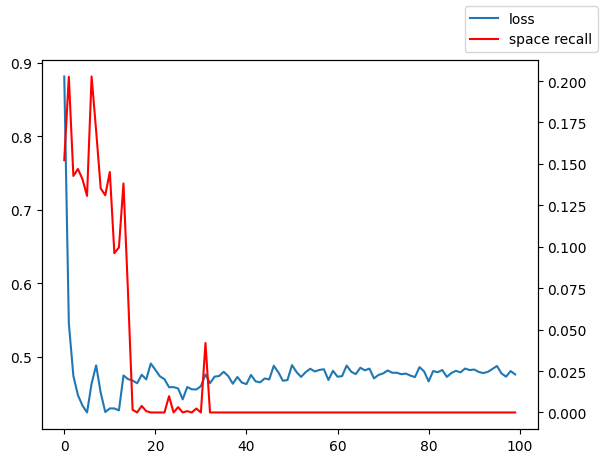

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
second_ax = ax.twinx()

ax.plot(history.history['loss'], label="loss")
second_ax.plot(history.history['space_recall'], label="space recall", color="red")
fig.legend()

In [22]:
model.evaluate(val_ds)

949/949 [==============================] - 13s 13ms/step - loss: 0.4798 - sparse_categorical_accuracy: 0.8161 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.6873 - char_recall: 1.0000 - char_f1: 0.8147


[0.4797550439834595,
 0.8160789608955383,
 0.0,
 0.0,
 nan,
 0.6873379945755005,
 1.0,
 0.8147010207176208]

In [23]:
preds = model([("dunningkruger", "eeeeeeeeeeeeeeeeeeeee", "thequickbrownfoxjumpedoverthelazydog"),(None,None, None)])
preds, tf.argmax(preds, axis=-1)

(<tf.Tensor: shape=(3, 100, 3), dtype=float32, numpy=
 array([[[-16.99924   ,   2.0721548 ,   0.4026579 ],
         [-16.99762   ,   2.0717075 ,   0.40232304],
         [-16.999203  ,   2.0721197 ,   0.4026194 ],
         [-16.999203  ,   2.0721197 ,   0.4026194 ],
         [-16.997372  ,   2.0716274 ,   0.4022716 ],
         [-16.999218  ,   2.0721533 ,   0.40265852],
         [-16.999245  ,   2.0721548 ,   0.40265906],
         [-16.999252  ,   2.0721607 ,   0.4026651 ],
         [-16.99762   ,   2.0717072 ,   0.4023228 ],
         [-16.99762   ,   2.071707  ,   0.40232238],
         [-16.999245  ,   2.0721548 ,   0.402659  ],
         [-16.996853  ,   2.0714152 ,   0.4020655 ],
         [-16.99762   ,   2.0717072 ,   0.4023228 ],
         [-17.01897   ,   2.077931  ,   0.40708598],
         [-17.016283  ,   2.0774305 ,   0.406688  ],
         [-17.019657  ,   2.0782142 ,   0.40728968],
         [-17.019958  ,   2.0783627 ,   0.40753227],
         [-17.019958  ,   2.0783627 ,   0.407

In [24]:
model.encoder.pos_embedding(tokenizer(["e"]))

<tf.Tensor: shape=(1, 100, 512), dtype=float32, numpy=
array([[[-0.8135057 ,  2.4654276 ,  1.954949  , ...,  0.56842756,
          0.9597004 ,  3.7965462 ],
        [ 0.5219509 , -0.16743678,  0.6210165 , ...,  1.9315889 ,
          0.2138592 ,  0.71559334],
        [ 0.58977735, -0.05287826,  0.7771991 , ...,  1.9315889 ,
          0.2138592 ,  0.71559334],
        ...,
        [ 0.06008768, -1.6146605 ,  0.5641642 , ...,  1.9315305 ,
          0.2138049 ,  0.7155428 ],
        [-0.89290196, -0.70424247, -0.27069739, ...,  1.9315293 ,
          0.21380377,  0.7155417 ],
        [-1.3187269 , -0.03914171, -1.0332861 , ...,  1.9315281 ,
          0.21380264,  0.7155407 ]]], dtype=float32)>

In [25]:
model.encoder.pos_embedding(tokenizer(["d"]))

<tf.Tensor: shape=(1, 100, 512), dtype=float32, numpy=
array([[[ 1.4004881 ,  0.32033703,  0.76646286, ...,  0.3870238 ,
         -0.3503027 , -1.6323583 ],
        [ 0.5219509 , -0.16743678,  0.6210165 , ...,  1.9315889 ,
          0.2138592 ,  0.71559334],
        [ 0.58977735, -0.05287826,  0.7771991 , ...,  1.9315889 ,
          0.2138592 ,  0.71559334],
        ...,
        [ 0.06008768, -1.6146605 ,  0.5641642 , ...,  1.9315305 ,
          0.2138049 ,  0.7155428 ],
        [-0.89290196, -0.70424247, -0.27069739, ...,  1.9315293 ,
          0.21380377,  0.7155417 ],
        [-1.3187269 , -0.03914171, -1.0332861 , ...,  1.9315281 ,
          0.21380264,  0.7155407 ]]], dtype=float32)>

In [26]:
import lovely_tensors as lt
lt.monkey_patch()
[print(x) for x in model.trainable_variables]

<tf.Variable 'space_segmentation_transformer/encoder/postional_embedding/embedding/embeddings:0' shape=(58, 512) dtype=float32, numpy=
array([[-0.01412093, -0.04372099, -0.00799673, ...,  0.0411708 ,
        -0.03474284, -0.01256912],
       [-0.02968057, -0.073121  , -0.08130331, ...,  0.03610411,
         0.01929422,  0.05080995],
       [-0.03595221,  0.10895754,  0.08639736, ..., -0.01907299,
        -0.00178101,  0.12359105],
       ...,
       [ 0.00896447, -0.01703224, -0.00899448, ..., -0.04177563,
        -0.0552373 ,  0.03061399],
       [-0.05058952,  0.02026631, -0.04149869, ..., -0.02427576,
        -0.07221463, -0.02539273],
       [-0.04887834,  0.01469706, -0.03826246, ..., -0.06998698,
        -0.0172425 , -0.01516993]], dtype=float32)>
<tf.Variable 'space_segmentation_transformer/encoder/encoder_sublayer_0/multi_head_attention/query/kernel:0' shape=(512, 3, 512) dtype=float32, numpy=
array([[[-7.43764918e-04,  2.94043142e-02,  1.38004776e-02, ...,
          1.84714645

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]